# TCP socket通信でラズパイから受け取った画像にF-RCNNを適応する

In [1]:
import os
import cv2
import numpy as np
import sys

# include parent directory 
sys.path.append(os.pardir)

import pickle
import time
from keras_frcnn import config
import keras_frcnn.resnet as nn
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras_frcnn import roi_helpers
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display
import socket               # Import socket module

%matplotlib inline


Using TensorFlow backend.


In [12]:
sys.setrecursionlimit(40000)

config_output_filename = 'configs/model_best_sss.pickle'

with open(config_output_filename, 'r') as f_in:
        C = pickle.load(f_in)

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

# put test data in this folder
img_path = 'data/1_shoe_only_data/forTest/'

In [13]:
def format_img(img, C):
    img_min_side = float(C.im_size)
    (height,width,_) = img.shape
 
    if width <= height:
        f = img_min_side/width
        new_height = int(f * height)
        new_width = int(img_min_side)
    else:
        f = img_min_side/height
        new_width = int(f * width)
        new_height = int(img_min_side)
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    img = img[:, :, (2, 1, 0)]
    img = img.astype(np.float32)
    img[:, :, 0] -= C.img_channel_mean[0]
    img[:, :, 1] -= C.img_channel_mean[1]
    img[:, :, 2] -= C.img_channel_mean[2]
    img /= C.img_scaling_factor
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    return img

In [14]:
class_mapping = C.class_mapping

if 'bg' not in class_mapping:
    class_mapping['bg'] = len(class_mapping)

class_mapping = {v: k for k, v in class_mapping.iteritems()}
print(class_mapping)

colors = [(255,255,255),(255,0,0),(0,0,255),(0,0,255)]
class_to_color = {class_mapping[v]: colors[index] for index, v in enumerate(class_mapping)}

# class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}
C.num_rois = int(32) # default : 32

if K.image_dim_ordering() == 'th':
    input_shape_img = (3, None, None)
    input_shape_features = (1024, None, None)
else:
    input_shape_img = (None, None, 3)
    input_shape_features = (None, None, 1024)


img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

{0: 'shoe', 1: 'bg'}


In [15]:
# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = nn.rpn(shared_layers, num_anchors)

classifier = nn.classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

all_imgs = []

classes = {}

bbox_threshold = 0.8

visualise = True

In [16]:
def analyze_show_pic(filepath, thresh_par_bbox):

    img = cv2.imread(filepath)

    X = format_img(img, C)

    img_scaled = np.transpose(X.copy()[0, (2, 1, 0), :, :], (1, 2, 0)).copy()
    img_scaled[:, :, 0] += 123.68
    img_scaled[:, :, 1] += 116.779
    img_scaled[:, :, 2] += 103.939

    img_scaled = img_scaled.astype(np.uint8)

    if K.image_dim_ordering() == 'tf':
        X = np.transpose(X, (0, 2, 3, 1))

    # get the feature maps and output from the RPN
    [Y1, Y2, F] = model_rpn.predict(X)


    R = roi_helpers.rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.6)
    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        for ii in range(P_cls.shape[1]):

            if np.max(P_cls[0, ii, :]) < thresh_par_bbox or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([16*x, 16*y, 16*(x+w), 16*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []
    
    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.3)
        count = 0
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            cv2.rectangle(img_scaled,(x1, y1), (x2, y2), class_to_color[key],2)

            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (x1, y1-0)

            # ラベル部分を実装したい場合は使う
#             cv2.rectangle(img_scaled, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
#             cv2.rectangle(img_scaled, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
#             cv2.putText(img_scaled, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)
            
            count += 1
#         print('Elapsed time = {}'.format(time.time() - st))
    
#     # count shoe
#     count = 0
# #     for key, value in bboxes.iteritems() :
# #         print key, value
#     for key in bboxes['shoe']:
#         count = count +1
    print count
    
    # put shoe Count label
    shoeCountPosition = (50, 50)
    shoeCount = "Number of shoe=" + str(count)
    (retval,baseLine) = cv2.getTextSize(shoeCount, cv2.FONT_HERSHEY_COMPLEX,1,1)        
    cv2.rectangle(img_scaled, (shoeCountPosition[0] - 5, shoeCountPosition[1]+baseLine - 5), (shoeCountPosition[0]+retval[0] + 5, shoeCountPosition[1]-retval[1] - 5), (0, 0, 0), 2)
    cv2.rectangle(img_scaled, (shoeCountPosition[0] - 5,shoeCountPosition[1]+baseLine - 5), (shoeCountPosition[0]+retval[0] + 5, shoeCountPosition[1]-retval[1] - 5), (255, 255, 255), -1)
    cv2.putText(img_scaled, shoeCount, shoeCountPosition, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)


    #     cv2.imshow('img', img_scaled) # 'cause Gtk-WARNING **: cannot open display;

    # save img
    cv2.imwrite('bbimg.jpg', img_scaled)

    # display img
    display.display(display.Image(filename="bbimg.jpg"))
    display.clear_output(wait=True)

13


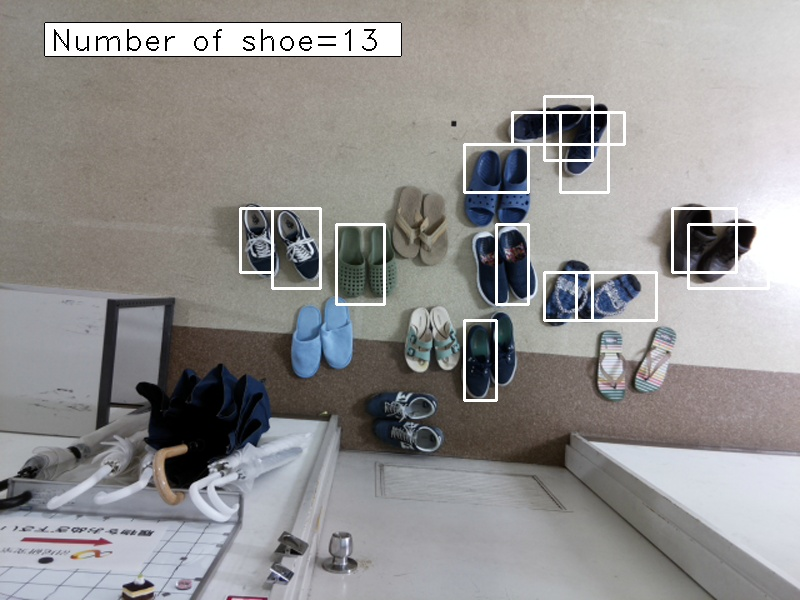

In [17]:
analyze_show_pic('1.png', 0.1)

In [11]:

host = ''                   # Get local machine name
port = 55000                # Reserve a port for your service.
s = socket.socket()
s.bind((host, port))        # Bind to the port
s.listen(5)                 # Now wait for client connection.
while True:
    # get latest_pic.jpg using socket connection
    c, address = s.accept()     # Establish connection with client.
    f = open('latest_pic.jpg', 'wb')
    print('Got connection from', address)
    l = c.recv(1024)
    while l:
        f.write(l)
        l = c.recv(1024)
    f.close()
    c.close()                # Close the connection
    print('closed connection')

    # analyse picture, show picture
    analyze_show_pic('latest_pic.jpg', 0.1)

KeyboardInterrupt: 